[*********************100%***********************]  1 of 1 completed


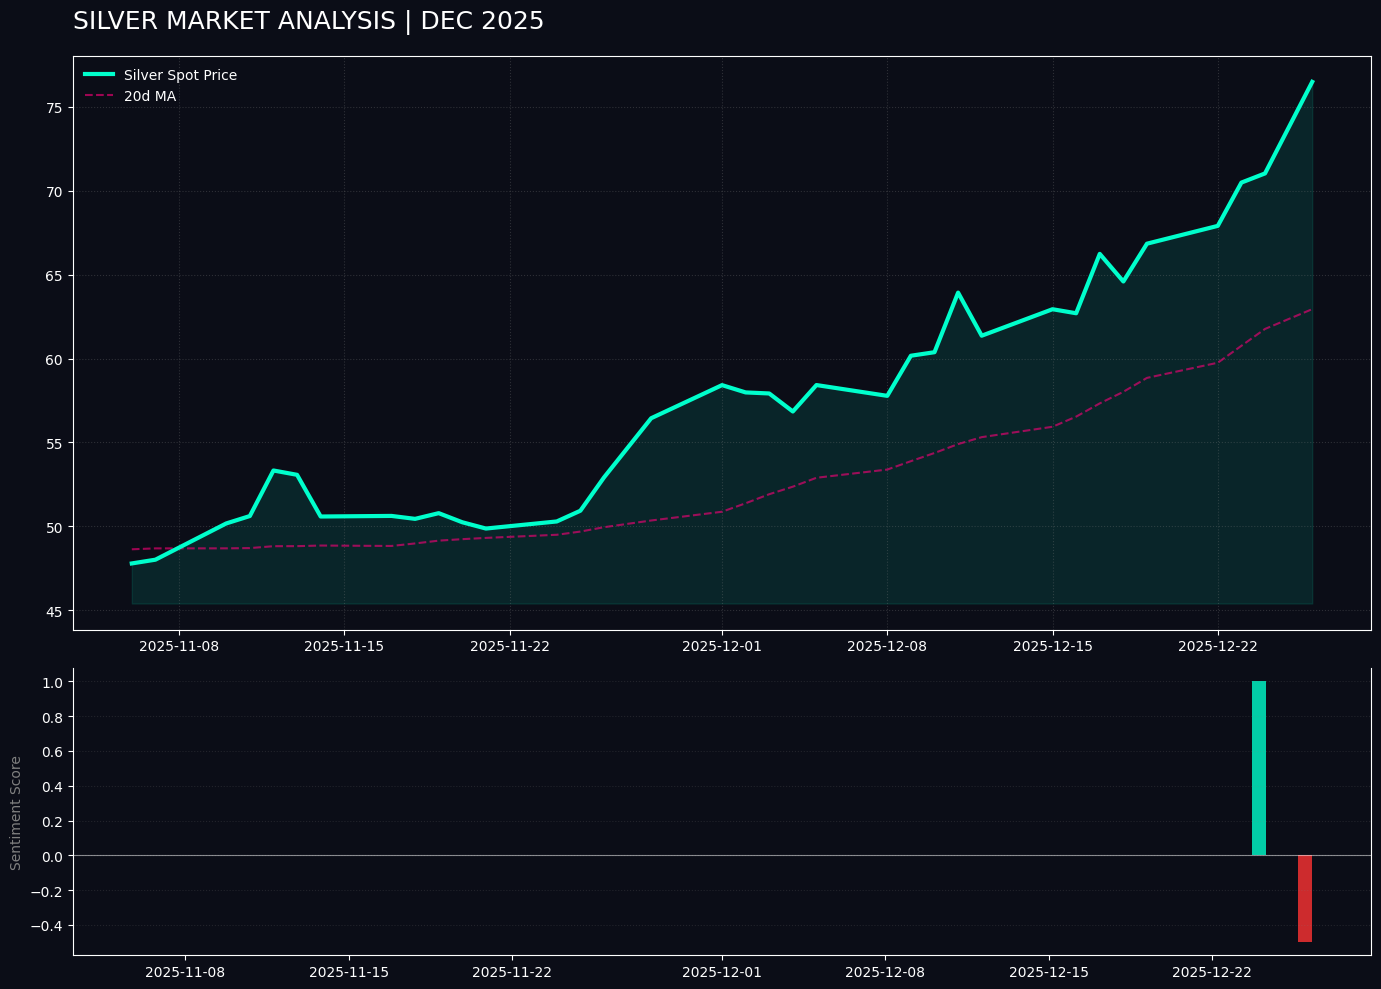


RANKED PREDICTORS: [('MA200', np.float64(0.6186532526567315)), ('Close', np.float64(0.30857938134761514)), ('MA20', np.float64(0.04936092697797633)), ('Price_Dist_MA200', np.float64(0.020415009111951658)), ('Vol_Change', np.float64(0.0029914299057253115)), ('Sentiment', np.float64(0.0))]


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Set a professional dark theme
plt.style.use('dark_background')

# 1. SETUP & DATA COLLECTION
ticker = "SI=F"
data = yf.download(ticker, start="2024-01-01", end="2025-12-30", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2. FEATURE ENGINEERING
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['Vol_Change'] = data['Volume'].pct_change()
data['Price_Dist_MA200'] = (data['Close'] - data['MA200']) / data['MA200']
data['Target'] = data['Close'].shift(-1)
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# 3. SENTIMENT MAPPING
news_events = {
    '2025-12-24': (1.0, "ATH: $80/oz"),
    '2025-12-26': (-0.5, "Margin Hike"),
    '2025-12-28': (-0.8, "Peace Rumors"),
    '2025-12-29': (-1.0, "CRASH")
}
data['Sentiment'] = [news_events.get(d.strftime('%Y-%m-%d'), (0.0, ""))[0] for d in data.index]

# 4. ML MODEL (Keep same logic)
features = ['Close', 'MA20', 'MA200', 'Vol_Change', 'Price_Dist_MA200', 'Sentiment']
train_size = int(len(data) * 0.8)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(data[features][:train_size], data['Target'][:train_size])

# 5. POLISHED VISUALIZATION
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})
fig.patch.set_facecolor('#0b0d17') # Deep navy background

# --- TOP PLOT: PRICE ACTION ---
ax1.set_facecolor('#0b0d17')
plot_data = data.tail(35)
ax1.plot(plot_data.index, plot_data['Close'], color='#00ffcc', linewidth=3, label='Silver Spot Price', zorder=3)
ax1.fill_between(plot_data.index, plot_data['Close'], plot_data['Close'].min()*0.95, color='#00ffcc', alpha=0.1)

# Highlight Moving Averages
ax1.plot(plot_data.index, plot_data['MA20'], color='#ff007a', linestyle='--', alpha=0.6, label='20d MA')

# Annotate Crash
crash_date = pd.Timestamp('2025-12-29')
if crash_date in plot_data.index:
    ax1.annotate('MARKET CRASH', xy=(crash_date, plot_data.loc[crash_date, 'Close']),
                 xytext=(crash_date, plot_data['Close'].max()),
                 arrowprops=dict(facecolor='#ff3333', shrink=0.05, width=2),
                 color='#ff3333', fontweight='bold', ha='center')

ax1.set_title('SILVER MARKET ANALYSIS | DEC 2025', loc='left', fontsize=18, color='white', pad=20)
ax1.legend(loc='upper left', frameon=False)
ax1.grid(color='gray', linestyle=':', alpha=0.3)

# --- BOTTOM PLOT: SENTIMENT BARS ---
ax2.set_facecolor('#0b0d17')
colors = ['#ff3333' if x < 0 else '#00ffcc' for x in plot_data['Sentiment']]
ax2.bar(plot_data.index, plot_data['Sentiment'], color=colors, alpha=0.8, width=0.6)
ax2.axhline(0, color='white', linewidth=0.8, alpha=0.5)

ax2.set_ylabel('Sentiment Score', color='gray')
ax2.grid(axis='y', color='gray', linestyle=':', alpha=0.2)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# 6. SUMMARY
importance = dict(zip(features, model.feature_importances_))
print(f"\nRANKED PREDICTORS: {sorted(importance.items(), key=lambda x: x[1], reverse=True)}")